In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:

from concerto.utils import universal_model
from cobra.flux_analysis.gapfilling import gapfill

from memote.experimental.config import ExperimentConfiguration

from syn_elong import model, exp_file_path as syn_pathfrom
from syn_elong.media import min_media


In [1]:


def create_ge_confusion_matrix(model, exp_file_path):
    """
    Runs gene essentially for a model and creates a confusion matrix plot

    Parameters
    ----------
    model : cobra.Model
    exp_file_path : str
        Path to experimental.yml file used by memote.

    Returns
    -------

    """
    experiment_data = ExperimentConfiguration(exp_file_path).load(model)
    cols = ['gene', 'essential']
    ge_simulated = experiment_data.essentiality['knockouts'].evaluate(model)[cols].copy()
    ge_experimental = experiment_data.essentiality['knockouts'].data[cols].copy()

    ge_simulated.set_index('gene', inplace=True)
    ge_experimental.set_index('gene', inplace=True)
    ge_experimental['predicted'] = ge_experimental['essential'].astype(bool)
    ge_simulated['actual'] = ge_simulated['essential'].astype(bool)
    del ge_simulated['essential']
    del ge_experimental['essential']
    merged = pd.concat([ge_experimental, ge_simulated], axis=1)

    tp = merged[~merged.actual & ~merged.predicted]
    fp = merged[merged.actual & ~merged.predicted]
    tn = merged[merged.actual & merged.predicted]
    fn = merged[~merged.actual & merged.predicted]

    conf_matrix = np.array(
        [tp.shape[0],  fn.shape[0], fp.shape[0], tn.shape[0]]
    ).reshape((2, 2))
    g = sns.heatmap(conf_matrix, annot=True, fmt='0.0f', cmap='Reds', cbar=False)
    g.set_xlabel("Actual Growth");
    g.set_ylabel("Predicted Growth");
    g.set_xticks([0.5, 1.5], ['+', '-']);
    g.set_yticks([0.5, 1.5], ['+', '-']);

    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}




Set parameter Username
Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "leghorn"


In [3]:
# update to media with all wavelengths of light
model.medium = min_media

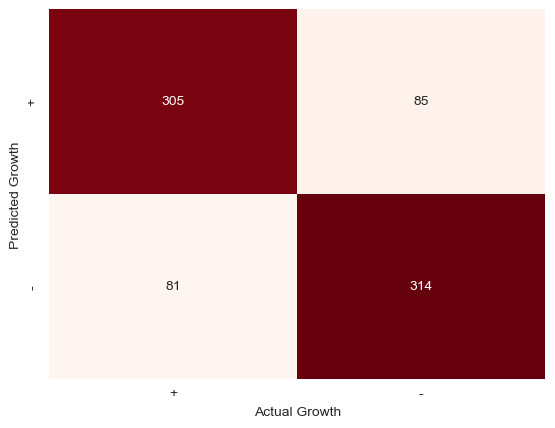

In [5]:
results = create_ge_confusion_matrix(model, syn_pathfrom)
plt.savefig("before_gapfill_after_update.png")

In [6]:
# access FP, FN, TP, TN
results['FP'].index.values

array(['SYNPCC7942_RS00005', 'SYNPCC7942_RS00015', 'SYNPCC7942_RS00345',
       'SYNPCC7942_RS00790', 'SYNPCC7942_RS00985', 'SYNPCC7942_RS01045',
       'SYNPCC7942_RS01140', 'SYNPCC7942_RS01500', 'SYNPCC7942_RS01505',
       'SYNPCC7942_RS01750', 'SYNPCC7942_RS01885', 'SYNPCC7942_RS02010',
       'SYNPCC7942_RS02165', 'SYNPCC7942_RS02185', 'SYNPCC7942_RS02255',
       'SYNPCC7942_RS13675', 'SYNPCC7942_RS02490', 'SYNPCC7942_RS02765',
       'SYNPCC7942_RS02940', 'SYNPCC7942_RS02945', 'SYNPCC7942_RS03055',
       'SYNPCC7942_RS03095', 'SYNPCC7942_RS03120', 'SYNPCC7942_RS03225',
       'SYNPCC7942_RS03355', 'SYNPCC7942_RS03380', 'SYNPCC7942_RS03485',
       'SYNPCC7942_RS03570', 'SYNPCC7942_RS04180', 'SYNPCC7942_RS04290',
       'SYNPCC7942_RS04440', 'SYNPCC7942_RS04750', 'SYNPCC7942_RS04830',
       'SYNPCC7942_RS04890', 'SYNPCC7942_RS05155', 'SYNPCC7942_RS05285',
       'SYNPCC7942_RS05330', 'SYNPCC7942_RS05635', 'SYNPCC7942_RS05765',
       'SYNPCC7942_RS13745', 'SYNPCC7942_RS06065', 

In [ ]:
def find_rxns(model, universal_model, gene):
    with model:
        model.genes.get_by_id(gene).knock_out()
        try:
            result = gapfill(
                model, 
                universal_model,
                demand_reactions=False, 
                exchange_reactions =False,
                iterations=4
            )
            for i, entries in enumerate(result):
                print("---- Run %d ----" % (i + 1))
                for e in entries:
                    print(e.id)
        except:
            print(f'{gene} no go')
            return [{gene:None}]
    return [{gene:result}]

rxns = []
for gene in results['FP'].index.values:
    rxns += find_rxns(model, universal_model, gene)
    

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpygm5g962.lp
Reading time = 0.02 seconds
: 924 rows, 2030 columns, 8354 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpaxfwz71z.lp
Reading time = 0.25 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS00005 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmppdhgwk39.lp
Reading time = 0.01 seconds
: 924 rows, 2030 columns, 8354 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpb6rth227.lp
Reading time = 0.17 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
---- Run 1 ----
PRFGS_1
---- Run 2 ----
PRFGS_1
---- Run 3 ----
PRFGS_1
---- Run 4 ----
PRFGS_1
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpcu0_9_aa.lp
Reading time = 0.01 seconds
: 924 rows, 2030 columns, 8354 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp1b2bt3z7.lp
Reading time = 0.19 seconds
: 15638 r

In [ ]:
rxns

In [ ]:
rxns_to_add = set()
for i in rxns:
#     print(i)
    for gene, rxn in i.items():
        if rxn is not None:
            good_rxns = [j.id for j in rxn[0]]
            print(gene, good_rxns)
            rxns_to_add.update(good_rxns)

In [ ]:
len(rxns_to_add)

In [ ]:
with open('rxns_to_add_for_ge.txt', 'w') as f:
    for i in rxns_to_add:
        f.writelines(i+'\n')
        print(i)
        print(universal_model.reactions.get_by_id(i))

In [ ]:
actual_rxns = [universal_model.reactions.get_by_id(i) for i in rxns_to_add]

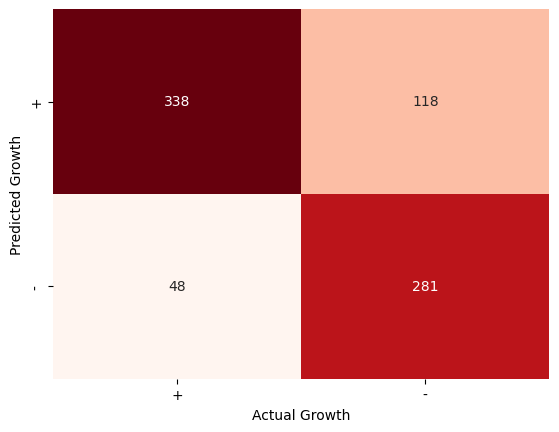

In [30]:
with model:
    model.add_reactions(actual_rxns)
    create_ge_confusion_matrix(model, syn_pathfrom)
    plt.savefig("after_gapfillafter_update.png")

In [ ]:
results = create_ge_confusion_matrix(model, syn_pathfrom

In [ ]:
)